## Example deTiN run using data from invitro mixing validation experiment

Loading data : 

In [415]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import deTiN
import deTiN_utilities as du
import deTiN_SSNV_based_estimate as dssnv
import deTiN_aSCNA_based_estimate as dascna
reload(deTiN) ### REMOVE THESE LINES
import optparse
args = optparse.Values()
args.mutation_data_path ='example_data/HCC_10_90.call_stats.pon_annotated.txt'
args.cn_data_path = 'example_data/HCC-1143_100_T-sim-final.acs.seg'
args.normal_het_data_path ='example_data/HCC_10_90.normal.hets.tsv'
args.tumor_het_data_path = 'example_data/HCC_10_90.tumor.hets.tsv'
args.output_dir = 'example_data/'
args.output_name = 'HCC_10_90'
args.exac_data_path = '.'
args.mutation_prior = 0.1
args.TiN_prior = 1
di = deTiN.input(args)
di.read_and_preprocess_data()

Estimate tumor in normal based on SSNVs : 

In [434]:
reload(dssnv)
# identify SSNV candidates based on MuTect and panel of normal flags 
di.candidates = du.select_candidate_mutations(di.call_stats_table)
# generate SSNV based model using candidate sites
ssnv_based_model = dssnv.model(di.candidates, di.mutation_prior)
ssnv_based_model.perform_inference()

pre-processing SSNV data
initialized TiN to 0
TiN inference after 1 iterations = 0.1
TiN inference after 2 iterations = 0.11
TiN inference after 3 iterations = 0.11
SSNV based TiN estimate converged: TiN = 0.11


Estimate tumor in normal based on aSCNAs

In [435]:
reload(dascna)
# filter input SNPs and identify regions of allelic imbalance 
di.aSCNA_hets = du.ensure_balanced_hets(di.seg_table,di.het_table)
di.aSCNA_segs = du.identify_aSCNAs(di.seg_table,di.aSCNA_hets)

identified convergent aSCNA in normal on chromosomes:[2]


In [436]:
# generate aSCNA based model 
ascna_based_model = dascna.model(di.aSCNA_segs, di.aSCNA_hets)
ascna_based_model.perform_inference()

calculating aSCNA based TiN estimate using data from chromosomes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 20]
detected 3 clusters
aSCNA based TiN estimate from modal TiN cluster :  0.12


In [457]:
reload(deTiN)
reload(du)
# calculate joint estimate and recover mutations 
do = deTiN.output(di,ssnv_based_model,ascna_based_model)
do.calculate_joint_estimate()
do.reclassify_mutations()
do.SSNVs.to_csv(path_or_buf=do.input.output_path + '/' + do.input.output_name + '_deTiN_SSNVs.txt',sep='\t')

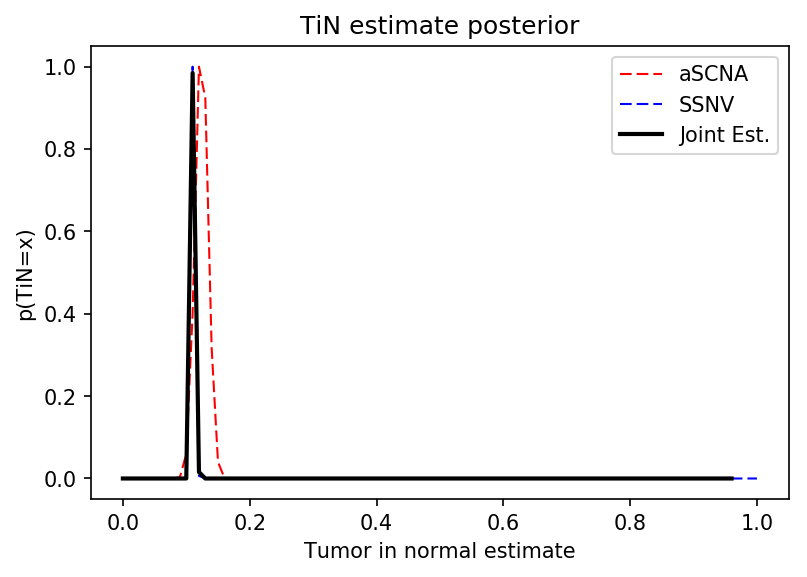

In [438]:
du.plot_TiN_models(do)

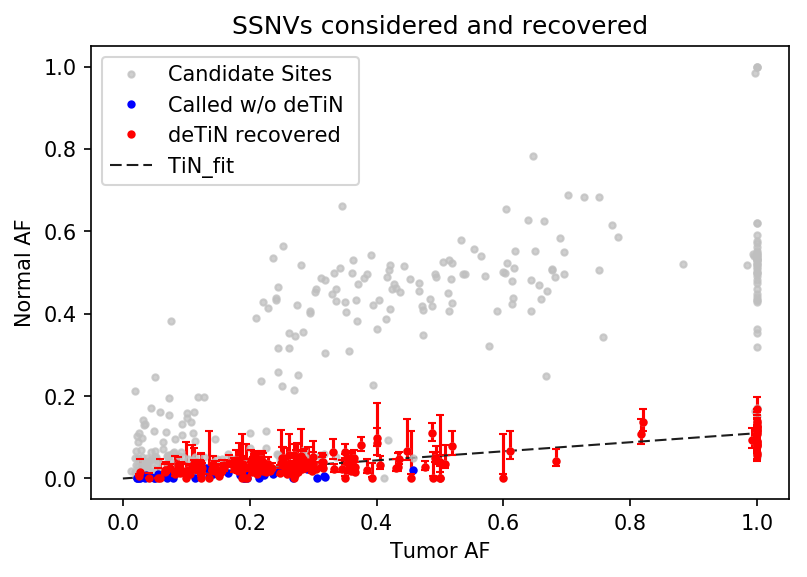

In [458]:
du.plot_SSNVs(do)

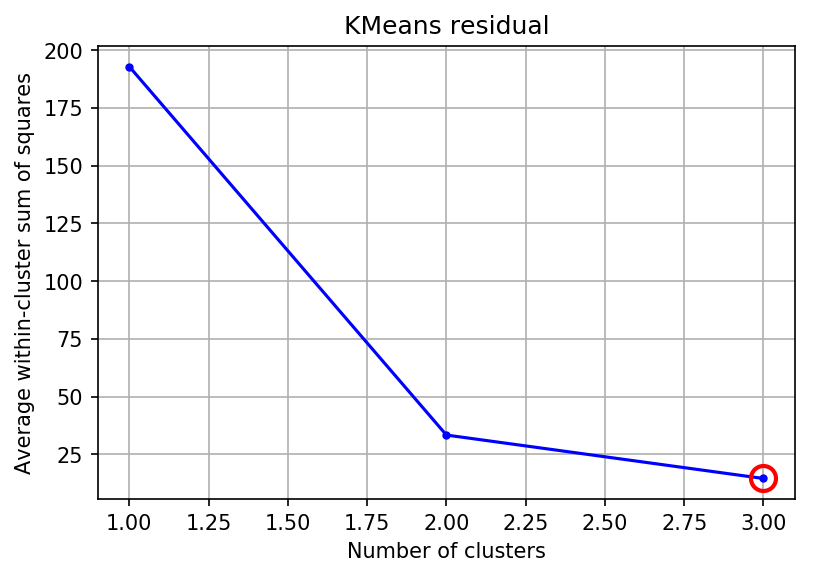

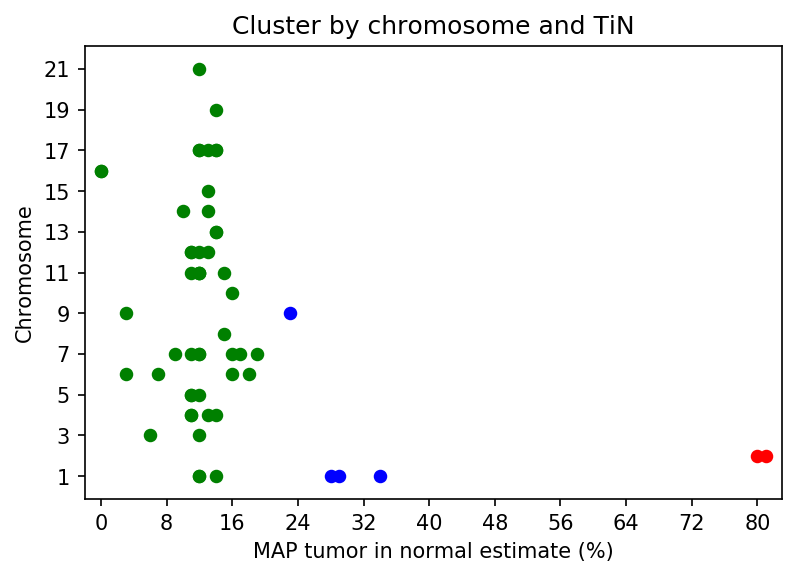

In [440]:
reload(du)

du.plot_kmeans_info(ascna_based_model,do.input.output_path,do.input.output_name)

In [470]:
do.SSNVs.to_csv(path_or_buf=do.input.output_path + '/' + do.input.output_name + '_deTiN_SSNVs.txt', sep='\t',index=None)
file = open(do.input.output_path + '/' + do.input.output_name + 'TiN_estimate_CI.txt', 'w')
file.write('%s - %s' % (str(do.CI_tin_low),str(do.CI_tin_high)))
file.close() 
file = open(do.input.output_path +'/' + do.input.output_name + 'TiN_estimate.txt', 'w')
file.write('%d' % (do.TiN))
file.close()